In [ ]:
#installing a package
#!pip3 install <package name> 

In [ ]:
# 2. remove jiwani hard coding apply any condition so that jiwani will be selected automatically...........done
# get islamic month and year from internet and put as an input
# 3. Make a method to process all files according to their Islamic Month name and Islamic date automatically
# 4. Calculate Parameters and recheck its accuracy with data 
# 5. Make GUI interface
# 6. Make it customizable code and reusable code apply OOP

In [205]:
import pandas as pd
import math 
import os
from fpdf import FPDF
import webbrowser
from datetime import datetime
import requests
import matplotlib.pyplot as plt
from datetime import timedelta


In [96]:
class MoonCalc:
    def __init__(self,file_path,date,Month,year,dst):
            self.path = file_path.replace('"','')
            self.date = date.replace('"','')
            self.month = Month.replace('"','')
            self.year = year.replace('"','')
            if dst != None:
                self.dst = dst.replace('"','')
    def data(self,*args):
        def set_axis(df):
            values = ["year","h","cd","conj",
                      "f","wk","mon","day","set",
                      "Saz","age","Alt","Maz","dz",
                      "Mag","El","mset","lag","best","cat"]
            df.set_axis(values,axis = 'columns',inplace = True)
            return df            
        def illum(a):#converting elongation to illumination
            val = 50*(1-math.cos(math.radians(a)))
            val = round(val, 1)
            return val
        try:
            df = pd.read_fwf(args[0]+'\\'+args[1])
        except:
            print("Error in loading a file: "+args[1])
        else: 
            df = set_axis(df)
            dfa = df.drop(['f','Mag','wk'],axis = 1)
            dfs = dfa.loc[:,:'conj']
            dfd = dfa.loc[:,'mon':'cat']
            dfd.fillna(method = 'bfill',inplace = True)
            dfs.fillna(method = 'ffill',inplace = True)
    #         #combining dfs
            dfg = dfs.combine_first(dfd)
            dfg.drop_duplicates(inplace = True)
            dfg.dropna(inplace = True)
    #         pd.set_option("display.max_rows", None,'display.max_columns', None)
            #set correct formats
            liste = ['conj','set','mset','best']
            for x in liste:dfg[x] = dfg[x].replace(' ',':',regex=True)
            listf = ['cd','day','year','lag','Alt','Saz','dz','Maz']
            for x in listf:dfg[x] = (dfg[x].astype(int)).astype(str)
            dfg['mon'] = dfg['mon'].str[:3]
            dfg['h'] = dfg['h'].str[:3]
            dfg['date'] = dfg['day']+dfg['mon']+dfg['year']
            dfg['date'] = pd.to_datetime(dfg['date'],format = '%d%b%Y')
            dfg = dfg.set_index('date')
            #create conjunction time column 
            dfg['conj_time'] = dfg['cd']+dfg['h']+dfg['year']+' '+dfg['conj']
            dfg['conj_time'] = pd.to_datetime(dfg['conj_time'])
            #create station column
            if args:
                dfg['Station'] = args[1].split('.',1)[0]
            else:
                dfg['Station'] = self.loc
            #Illumination calculation in func-->illum using Elongation 
            dfg['El'] = dfg['El'].astype(int)
            dfg['ilum'] =  dfg.apply(lambda row : illum(row['El']), axis = 1)
            return dfg        #load data
    def sort(self,*args):#sorting the columns in desired order
        df = self.data(args[0],args[1])
        dfs = pd.DataFrame(df[['Station','set','lag','Alt','Saz','dz','El','ilum','cat','age','conj_time']])
#         sorter = ['Karachi', 'Quetta','Lahore','Islamabad','Peshawar','Jiwani','Gilgit','Multan','Muzaffarabad','Dir','Mansehra','Cherat','Swabi']
#         dfs.Station = dfs.Station.astype("category").cat.set_categories(sorter)
        dfs.Station = dfs.Station.astype("category").cat.set_categories(sorted(dfs.Station.unique()))

        return dfs        
    def all_files(self):# read all files and returns its df
        directory = self.path
        d = []
        df = pd.DataFrame()
        if os.path.exists(directory) == True:
            for root, dirs, files in os.walk(directory):
                for filename in files:
                    d = pd.DataFrame(self.sort(root,filename))
                    df = df.append(d)  
                return df
        else: 
            print("directory does not exist")
            return(df)             
    def calculate(self):#returns df with required values                
        dfs = self.all_files()
        date = self.date
        dfd = pd.DataFrame()
        if dfs.empty == False:
            if dfs.loc[date].empty == False:
                dfs = dfs.loc[date].sort_values(['Station'])
                dfd = dfs.loc[:,:'cat']
                dfd.Station = dfd.Station.astype(str) + "(" + dfd.set.astype(str)+")"
                dfd.drop(columns = "set", inplace = True)
                dfd.rename(columns = {'Station':'STATION(Sunset)','lag':'LAG TIME(Minutes)','Alt':'MOON ALTITUDE(Degrees)', 
                                      'Saz':'SUN_AZIMUTH(Degrees)',
                                      'dz':'DAZ(Degrees)',
                                      'El':'ELONGATION(Degrees)','ilum':'ILLUMINATION(%)',
                                      'cat':'CRITERION'}, inplace = True)               
                    
                return dfd
        return dfd
    def Select_city(self):# Select city according to highest sunset time and return df
        date = self.date
        dfs = self.all_files()
        date = self.date
        if dfs.empty == False:
            if dfs.loc[date].empty == False:
                dfs = dfs.loc[date].sort_values(['Station'])
                dfs = dfs[dfs["set"] == dfs["set"].max()]
                
            else:
                print("Max df is not selected")
                
        return{
            "age" : dfs.age.values[0].split(" "),
            "dt" : str(dfs.conj_time.dt.strftime("%d-%m-%Y").values[0]),
            "tm" : str(dfs.conj_time.dt.strftime("%H:%M:%S").values[0]),
            "city": dfs.Station.values[0]
        }
            
            # return df with jiwani row only
    def pdf(self):
        Format = "Arial"        
        data = {'Station':'  STATION    (Sunset)','lag':'LAG TIME  (Min)','Alt':'MOON ALTITUDE   (Deg)', 
                                      'Saz':'SUN_AZIMUTH (Deg)',
                                      'dz':'DAZ   (Deg)  ',
                                      'El':'ELONGATION  (Deg)','ilum':'ILLUMINATION  (%)',
                                      'cat':'CRITERION   '}
        df = pd.DataFrame()
        df = self.calculate()
        if df.empty == True: return print("Date not Found") 
        Date = datetime.strptime(self.date,"%Y-%m-%d")
        Date =Date.strftime("%d-%m-%Y")
        pdf = PDF(self.path, self.date, self.month, self.year , self.dst ,'L', 'mm', 'A4')
        pdf.add_page()
        pdf.set_font(Format,'B',11)
        li = []
        for x in data.values():li.append(x)
        width = [40,30,38,33,22,31,33,26,40,40]
        start = 25
        pdf.x = start
        offset = pdf.x + width[0]
        sx = pdf.x
        i = 0
        top = 40
        pdf.y = top
        for head in li:    
            pdf.multi_cell(width[i],7,head,border = 1,align = "C")
            # Reset y coordinate
            pdf.y = top
            # Move to computed offset    
            pdf.x = offset
            i += 1
            offset = offset+ width[i]
        h = pdf.font_size * 2.5
        pdf.y = 54
        pdf.set_font(Format,'',11)
        for index, row in df.iterrows():
            i = 0
            pdf.x = start
            for data in row.values:
                pdf.cell(width[i], h, str(data),border = 1,align='C') # write each data for the row in its cell
                i +=1  
            pdf.ln()      
        ls = ["(A)  Easily visible",
                         "(B) Visible under perfect conditions",
                         "(C)  May need optical aid to find the crescent Moon",
                        "(D)  Will need optical aid to find the crescent Moon",
                        "(E)  Not visible with a telescope",
                        "(F)  Not visible, below the Danjon limit"]
        
        pdf.ln()
        pdf.set_font(Format, 'BU', 12)
        h = 5
        pdf.ln()
        pdf.set_font(Format, '', 11)
        if self.dst:
            pdf.output(self.dst+"\\"+Date+".pdf",'F')
#             webbrowser.open_new(self.dst+"\\"+Date+'.pdf')
        else:
            pdf.output(Date+'.pdf','F') # save pdf
#             webbrowser.open_new(Date+'.pdf') # open pdf in browser  


In [95]:
class PDF(FPDF, MoonCalc):
    def __init__(self, file_path, date, Month, year, dst, *args, **kwargs):
        # Initialize FPDF
        FPDF.__init__(self, *args, **kwargs)  
        
        # Initialize MoonCalc with required parameters
        MoonCalc.__init__(self, file_path, date, Month, year, dst)

    
    def footer(self):
        self.set_y(-27)
        Format = "Arial"
        
        # Visibility Criterion
        ls = [
            "(A)  Easily visible",
            "(B)  Visible under perfect conditions",
            "(C)  May need optical aid to find the crescent Moon",
            "(D)  Will need optical aid to find the crescent Moon",
            "(E)  Not visible with a telescope",
            "(F)  Not visible, below the Danjon limit"
        ]

        self.set_font(Format, 'BU', 12)
        self.cell(297, 5, "Visibility Criterion:", ln=1, align='L')
        self.ln(2)

        self.set_font(Format, '', 11)
        sp = "  "
        self.multi_cell(280, 5, txt=sp.join(ls), align='L')
        
        self.set_font(Format, 'I', 8)
        self.cell(270, 10, 'Computer Generated', 0, 0, 'R')

        self.ln(5)

    def header(self):
        data = self.Select_city()

        age = data["age"]
        dt = data["dt"]
        tm = data["tm"]
        city = data["city"]

        Format = "Arial"        

        Date = datetime.strptime(self.date, "%Y-%m-%d")
        Date = Date.strftime("%d-%m-%Y")

        self.set_font(Format, 'B', 16)
        h = 7
        w = 297
        self.cell(w, h, txt="PARAMETERS OF THE NEW MOON " + self.month + " " + self.year, ln=1, align='C')
        self.cell(w, h, txt="AT THE TIME OF SUNSET ON " + Date, ln=1, align='C')
        self.cell(w, h, txt=f"(Conjunction on {dt} {tm} PST) ", ln=1, align='C')
        self.cell(w, h, txt = f"Moon Age at the time of Sunset on {Date} ({city}): {age[0]} hrs {age[1]} mins",ln = 1, align = 'C')
        self.ln()



In [199]:
def get_hijri_date(date):
    """
    Convert a Gregorian date (YYYY-MM-DD) to an Islamic (Hijri) date and get the next Islamic month.
    
    :param georgian_date: str, Gregorian date in 'YYYY-MM-DD' format
    :return: dict, Hijri date details including next Islamic month
    """
    try:
        # Convert date from YYYY-MM-DD to DD-MM-YYYY for API
        converted_date =date
        
        # API URL with formatted date
        url = f"https://api.aladhan.com/v1/gToH/{converted_date}?calendarMethod=UAQ"
        
        # Send GET request
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:
            data = response.json()  # Convert response to JSON
            
            # Extract Hijri date details
            hijri_date = data["data"]["hijri"]["date"]  # Example: "28-08-1446"
            hijri_month = data["data"]["hijri"]["month"]["en"].upper()  # Convert to uppercase
            hijri_day = data["data"]["hijri"]["day"]  # Example: "28"
            hijri_year = int(hijri_date.split('-')[2])  # Convert year to integer
            
            # Get current Hijri month number
            hijri_month_number = data["data"]["hijri"]["month"]["number"]-1 # Example: 8 for Sha'ban
            
            # List of Islamic months in uppercase
            ISLAMIC_MONTHS = [
                "MUHARRAM", "SAFAR", "RABI UL AWWAL", "RABI US SANI",
                "JUMADI UL-AWWAL", "JUMADI US SANI", "RAJAB", "SHABAN",
                "RAMADAN", "SHAWWAL", "ZUL-QADDAH", "ZUL-HIJJAH"
            ]
            
            # Calculate next Islamic month
            next_hijri_month = ISLAMIC_MONTHS[hijri_month_number % 11]  # Modulo to cycle months  
            
#             If next month is MUHARRAM, increment the Hijri year
#             if next_hijri_month == "MUHARRAM":
#                 hijri_year += 1
            
            return {
                "hijri_day": hijri_day,
                "hijri_month": ISLAMIC_MONTHS[hijri_month_number],
                "hijri_year": str(hijri_year)
            }
        else:
            return {"error": "Failed to fetch Hijri date"}
    
    except Exception as e:
        return {"error": str(e)}

# Example Usage
# georgian_date = "01-03-2033"
# hijri_data = get_hijri_date(georgian_date)
# print(hijri_data['hijri_month'])

# # Check if an error occurred
# if "error" in hijri_data:
#     print("Error:", hijri_data["error"])
# else:
#     print(f"Hijri Date: {hijri_data['hijri_day']} {hijri_data['hijri_month']}, {hijri_data['hijri_year']} Hijri")
# #     print(f"Next Islamic Month: {hijri_data['next_hijri_month']}")


In [200]:
def next_date(date):
    return pd.Timestamp(date) + pd.Timedelta(days=1)

In [201]:

"""
Purpose:
This script generates an Islamic (Hijri) calendar up to the year 2035 based on moon sighting data. 
It follows these steps:
1. Reads precomputed moon sighting data from a specified directory.
2. Converts a given Gregorian date to the corresponding Hijri date.
3. Sorts moon sighting data for a specific location ('Jiwani.txt').
4. Identifies dates where moon sighting categories are 'A' or 'B' (indicating valid sightings).
5. Determines the next day as the first day of the new Hijri month.
6. Converts the next date to Hijri format and stores relevant details.
7. Saves the processed calendar data in a CSV file ('Calendar.csv').

Output:
- A CSV file containing the Hijri calendar dates for future years.
"""

# Import necessary libraries
from datetime import datetime
import pandas as pd

# Define the path where data files are stored
path = "D:/code/Moon_predictor/Data_2035"

# Set the starting Gregorian date
date = "28-02-2025"

# Define the output directory
dst = 'D:/Output'

# Convert the given Gregorian date to the Hijri (Islamic) calendar
hijri_data = get_hijri_date(date)
month = hijri_data['hijri_month']  # Extract Hijri month
year = hijri_data['hijri_year']    # Extract Hijri year

# Convert the date string into a datetime object
date_obj = datetime.strptime(date, "%d-%m-%Y")    

# Convert the date to YYYY-MM-DD format
converted_date = date_obj.strftime("%Y-%m-%d")

# Initialize the MoonCalc class to compute lunar calendar details
Moon = MoonCalc(path, converted_date, month, year + " AH", dst)

# Sort moon sighting data for the location 'Jiwani.txt'
jiwani = Moon.sort(path, 'Jiwani.txt')

# Initialize empty lists to store processed date information
lista = []
listb = []

# Iterate over all dates in the sorted moon sighting data
for date in jiwani.index.date:
    # Retrieve moon sighting data for the given date
    jiwani_data = jiwani.loc[str(date)]

    # Check if the category is 'A' or 'B' (indicating valid sightings)
    if jiwani_data['cat'] == 'A' or jiwani_data['cat'] == 'B': 
        # Get the next date after the sighting
        ndate = next_date(date)

        # Convert the next date to the required format
        date_obj = datetime.strptime(str(ndate.date()), "%Y-%m-%d")    
        converted_date = date_obj.strftime("%d-%m-%Y")

        # Get the Hijri date for the next day
        hijri_data = get_hijri_date(converted_date)
        month = hijri_data['hijri_month']
        year = hijri_data['hijri_year']
        day = hijri_data['hijri_day']

        # Append relevant data to lista (assuming first day of Hijri month starts here)
        lista.append([year, month, '1', ndate.day, ndate.month, ndate.year])          

# Convert the lista into a DataFrame and save it as a CSV file
df = pd.DataFrame(lista)
df.to_csv('Calendar.csv')

# Create another DataFrame from listb (though it's not being populated in this code)
df2 = pd.DataFrame(listb)

In [202]:
# Remove duplicate values in the DataFrame and save the corrected version

# Read the 'Calendar.csv' file into a DataFrame
# Assign column names: 'iyear' (Islamic year), 'imonth' (Islamic month), 'iday' (Islamic day), 
# 'day' (Gregorian day), 'month' (Gregorian month), 'year' (Gregorian year)
df1 = pd.read_csv('Calendar.csv', names=["iyear", "imonth", "iday", 'day', 'month', 'year'], header=0)

# Remove duplicate rows based on 'iyear', 'imonth', and 'iday' columns
# This ensures that only the first occurrence of each unique Hijri date is kept
df1 = df1[~df1.duplicated(subset=['iyear', 'imonth', 'iday'], keep='first')]

# Store the cleaned DataFrame as 'calendar'
calendar = df1

# Save the corrected calendar data to a new CSV file
calendar.to_csv('Calendar_corrected.csv')

    

In [210]:
# Here's the Python code to expand the DataFrame and fill in the missing Islamic dates until the next month's start. This code:

# Iterates through the given rows.

# Fills in all missing dates between each Islamic month.

# Maintains iyear and imonth while incrementing iday.

dff = pd.DataFrame(calendar)  # Renamed DataFrame

# Reset index to ensure sequential integer indexing
dff = dff.reset_index(drop=True)

# Initialize an empty list to store expanded rows
expanded_data = []


# Iterate through each row except the last one
for i in range(len(dff) - 1):
    start_date = pd.Timestamp(year=dff.loc[i, "year"], month=dff.loc[i, "month"], day=dff.loc[i, "day"])
    end_date = pd.Timestamp(year=dff.iloc[i + 1]["year"], month=dff.iloc[i + 1]["month"], day=dff.iloc[i + 1]["day"]) - timedelta(days=1)
    
    # Generate all dates between start_date and end_date
    current_iday = dff.loc[i, "iday"]  # Start Islamic date
    current_imonth = dff.loc[i, "imonth"]
    current_iyear = dff.loc[i, "iyear"]
    
    while start_date <= end_date:
        expanded_data.append([current_iyear, current_imonth, current_iday, start_date.day, start_date.month, start_date.year])
        start_date += timedelta(days=1)
        current_iday += 1  # Increment Islamic date

# Convert expanded data to DataFrame
expanded_dff = pd.DataFrame(expanded_data, columns=["iyear", "imonth", "iday", "day", "month", "year"])

# Save to CSV
expanded_dff.to_csv("expanded_hijri_gregorian_calendar.csv", index=False)

print("Expanded DataFrame saved as 'expanded_hijri_gregorian_calendar.csv'")

Expanded DataFrame saved as 'expanded_hijri_gregorian_calendar.csv'


In [97]:
def executable():
    path = "D:/code/Moon_predictor/Data_2035"
    date = "28-02-2025"
    dst = 'D:/Output'
#     path = input("Input data directory(Drag and drop): ")
#     dst = input("Output file destination(Drag and drop): ")
#     date = input("Date (dd-mm-yyyy): ")
    hijri_data = get_hijri_date(date)
    month = hijri_data['hijri_month']
    year = hijri_data['hijri_year']
    date_obj = datetime.strptime(date, "%d-%m-%Y")    
    # Convert to YYYY-MM-DD format
    converted_date = date_obj.strftime("%Y-%m-%d")
    Moon = MoonCalc(path,converted_date,month,year +" AH",dst)
    df = Moon.all_files().index.date
    for date in df:
        date_obj = datetime.strptime(str(date), "%Y-%m-%d")    
        converted_date = date_obj.strftime("%d-%m-%Y")
        hijri_data = get_hijri_date(str(converted_date))
        month = hijri_data['hijri_month']
        year = hijri_data['hijri_year']
        print("Currently Processing :"+converted_date+".pdf file")
        Moon = MoonCalc(path,str(date),month,year + " AH", dst)

        try:
            Moon.pdf()
        except Exception as e:
            return {"error": str(e)}

# Convert each date to "YYYY-MM-DD" string format
    date_list = [date.strftime("%Y-%m-%d") for date in df]

    print(date_list)  # List of date strings
    Moon.pdf()
# executable() # uncomment this line to generate all files upto 2035

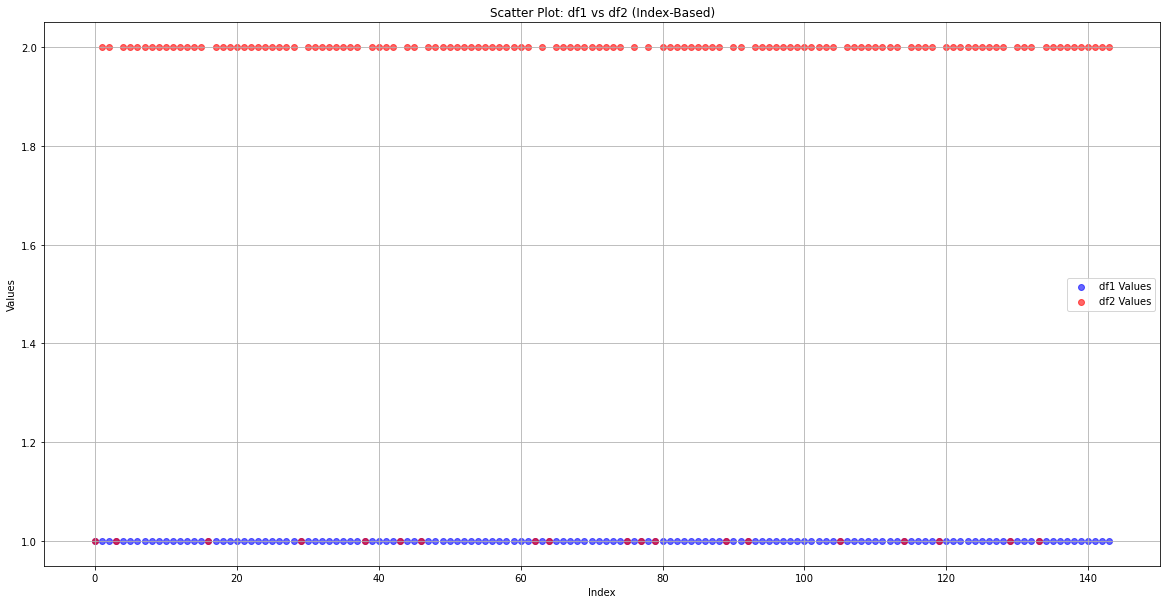

In [183]:

dfs = pd.DataFrame({'Value':df[2]})
dfd = pd.DataFrame({'Value': df2[3]})
dfs['Value'] = pd.to_numeric(dfs['Value'], errors='coerce')
dfd['Value'] = pd.to_numeric(dfd['Value'], errors='coerce')

dfs.index = dfd.index

# Scatter plot based on index
plt.figure(figsize=(20, 10))
plt.scatter(dfs.index, dfs['Value'], color='blue', alpha=0.6, label='df1 Values')
plt.scatter(dfd.index, dfd['Value'], color='red', alpha=0.6, label='df2 Values')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot: df1 vs df2 (Index-Based)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [98]:
while True:
    executable()
#     print("\nReport generated. Restarting...\n")
    
#     # Ask the user if they want to continue or exit
#     restart = input("Do you want to generate another report? (yes/no): ").strip().lower()
#     if restart not in ["yes", "y"]:
#         print("Exiting program.")
#         break  # Exit loop if the user doesn't want to continue


Currently Processing :29-01-2025.pdf file
Currently Processing :30-01-2025.pdf file
Currently Processing :28-02-2025.pdf file
Currently Processing :01-03-2025.pdf file
Currently Processing :29-03-2025.pdf file
Currently Processing :30-03-2025.pdf file
Currently Processing :28-04-2025.pdf file
Currently Processing :27-05-2025.pdf file
Currently Processing :28-05-2025.pdf file
Currently Processing :25-06-2025.pdf file
Currently Processing :26-06-2025.pdf file
Currently Processing :25-07-2025.pdf file
Currently Processing :26-07-2025.pdf file
Currently Processing :23-08-2025.pdf file
Currently Processing :24-08-2025.pdf file
Currently Processing :22-09-2025.pdf file
Currently Processing :23-09-2025.pdf file
Currently Processing :21-10-2025.pdf file
Currently Processing :22-10-2025.pdf file
Currently Processing :23-10-2025.pdf file
Currently Processing :20-11-2025.pdf file
Currently Processing :21-11-2025.pdf file
Currently Processing :22-11-2025.pdf file
Currently Processing :20-12-2025.p

Currently Processing :05-09-2032.pdf file
Currently Processing :06-09-2032.pdf file
Currently Processing :05-10-2032.pdf file
Currently Processing :06-10-2032.pdf file
Currently Processing :03-11-2032.pdf file
Currently Processing :04-11-2032.pdf file
Currently Processing :03-12-2032.pdf file
Currently Processing :04-12-2032.pdf file
Currently Processing :01-01-2033.pdf file
Currently Processing :02-01-2033.pdf file
Currently Processing :31-01-2033.pdf file
Currently Processing :01-02-2033.pdf file
Currently Processing :01-03-2033.pdf file
Currently Processing :02-03-2033.pdf file
Currently Processing :31-03-2033.pdf file
Currently Processing :01-04-2033.pdf file
Currently Processing :29-04-2033.pdf file
Currently Processing :30-04-2033.pdf file
Currently Processing :28-05-2033.pdf file
Currently Processing :29-05-2033.pdf file
Currently Processing :27-06-2033.pdf file
Currently Processing :28-06-2033.pdf file
Currently Processing :26-07-2033.pdf file
Currently Processing :27-07-2033.p

KeyboardInterrupt: 

In [ ]:
def data():
    path = "..\\moon data"
    def set_axis(df):
        values = ["year","h","cd","conj",
                  "f","wk","mon","day","set",
                  "Saz","age","Alt","Maz","dz",
                  "Mag","El","mset","lag","best","cat"]
        df.set_axis(values,axis = 'columns',inplace = True)
        return df            
    def illum(a):#converting elongation to illumination
        val = 50*(1-math.cos(math.radians(a)))
        val = round(val, 1)
        return val
    try:
        df = pd.read_fwf(path+"/Lahore.txt")
    except:
        print("")
    else: 
        df = set_axis(df)
        dfa = df.drop(['f','Mag','wk'],axis = 1)
        dfs = dfa.loc[:,:'conj']
        dfd = dfa.loc[:,'mon':'cat']
        dfd.fillna(method = 'bfill',inplace = True)
        dfs.fillna(method = 'ffill',inplace = True)
#         #combining dfs
        dfg = dfs.combine_first(dfd)
        dfg.drop_duplicates(inplace = True)
        dfg.dropna(inplace = True)
#         pd.set_option("display.max_rows", None,'display.max_columns', None)
        #set correct formats
        liste = ['conj','set','mset','best']
        for x in liste:dfg[x] = dfg[x].replace(' ',':',regex=True)
        listf = ['cd','day','year','lag','Alt','Saz','dz','Maz']
        for x in listf:dfg[x] = (dfg[x].astype(int)).astype(str)
        dfg['mon'] = dfg['mon'].str[:3]
        dfg['h'] = dfg['h'].str[:3]
        dfg['date'] = dfg['day']+dfg['mon']+dfg['year']
        dfg['date'] = pd.to_datetime(dfg['date'],format = '%d%b%Y')
        dfg = dfg.set_index('date')
        #create conjunction time column 
        dfg['conj_time'] = dfg['cd']+dfg['h']+dfg['year']+' '+dfg['conj']
        dfg['conj_time'] = pd.to_datetime(dfg['conj_time'])
        #create station column
#         if args:
#             dfg['Station'] = args[1].split('.',1)[0]
#         else:
#             dfg['Station'] = self.loc
        #Illumination calculation in func-->illum using Elongation 
        dfg['El'] = dfg['El'].astype(int)
        dfg['ilum'] =  dfg.apply(lambda row : illum(row['El']), axis = 1)
        return dfg        #load data

In [ ]:
df = pd.DataFrame(data())
df = df.drop(['El','Saz','Maz','best','cd','conj','day','mon','year','dz','h','lag','mset','set','conj_time'],axis = 1)
# df.columns = ['cat','ilum','age','Alt']
df = df.drop(df.loc['2023'].index)
df = df.drop(df.loc['2024'].index)

# df = df[df['cat'].str.contains('A|B|C')]
months = ['Muharram', 'Safar', 'Rabi-ul-Awwal', 'Rabi-us-Sani', 
          'Jamadi-ul-Awwal', 'Jamadi-us-Sani', 'Rajab', 'Shaban', 'Ramadan', 'Shawwal',' Ziquad',' ZilHaj']


In [ ]:
dfs = pd.DataFrame(df.index.to_series().diff().dt.days)
df = pd.concat([df, dfs], axis=1)
df = df.replace(np.nan, 0)
df['date'] = df['date'].astype(int)
df.rename(columns={'date':'diff'},inplace = True)


In [ ]:
df['Alt'] = pd.to_numeric(df['Alt'])

In [ ]:
# Get color for each data point
colors = {'A': 'green', 'B': 'blue','C': 'orange','D' : 'yellow', 'E' : 'purple', 'F' : 'Red'}
color_list = [colors[group] for group in df['cat']]

# Create a scatter plot with color-coding based on 'categorical_variable'
ax = df.plot.scatter('ilum',
                'Alt',
                c=color_list,
                grid=True,  figsize=(10, 6),).get_figure()

# Create legend handles, labels for each group and add legend to the plot
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=colors['A'], label='A'),
    mpatches.Patch(color=colors['B'], label='B'),
    mpatches.Patch(color=colors['C'], label='C'),
    mpatches.Patch(color=colors['D'], label='D'),
    mpatches.Patch(color=colors['E'], label='E'),
    mpatches.Patch(color=colors['F'], label='F'),# add as many as needed
]
ax.legend(handles=legend_handles,
          loc='upper right')
plt.xlabel("MOON ILLUMINATION")
plt.ylabel("MOON ALTITUDE")
plt.show()
ax.savefig('scatter.png',dpi = 400)

In [ ]:
ax1 = df.plot.scatter(x='cat',

                      y='ilum',x = "Categories",y = "illumination").get_figure()

ax1.set_xlabel('Criterion')
ax1.set_ylabel('illumination')
ax1.savefig('foo.png',dpi = 400)

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)